## Import Libraries

In [ ]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import tensorflow as tf
print("tensorflow version: {}".format(tf.__version__))

#misc libraries
import random
import time
import os
import re

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.0.1
matplotlib version: 3.2.1
NumPy version: 1.18.3
SciPy version: 1.4.1
IPython version: 7.12.0
scikit-learn version: 0.22.1
tensorflow version: 2.1.0
-------------------------


In [ ]:
#Deep Learning Tools
from tensorflow.keras import models, layers, regularizers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

#Common Model Algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn import feature_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import SMOTENC


#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import seaborn as sns
import pandas_profiling as pp
from sklearn.inspection import permutation_importance

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set()
#pylab.rcParams['figure.figsize'] = 12,8

## Self Def Functions

In [ ]:
def Sort_Columns(ColNames):
  Parameter = list(map(lambda x: x.rsplit('_',1)[1] if len(x.rsplit('_',1))>1 else x,
                       ColNames))
  Sorted_Tuple = sorted(zip(Parameter,ColNames),key = lambda x:x[0])
  return [col for (index,col) in Sorted_Tuple]

In [ ]:
def Pretty_Print(ColNames,FeaturesName,Print_Col = 3, length = 100):
  ##Self Define ColName Print Format
  def Pretty_ColName(ColName):
    ColName_ = ColName.rsplit('_',1)
    ColName_ = ColName_[::-1]

    if len(ColName_)>1:
      Number = ColName_[0]

      if re.match(r'[A-Z]+',Number):
        Number = ' '*5
        ColName_[1] = ColName
      elif re.match(r'[0-9]+[A-Z]',Number):
        Number = Number.rjust(5)
      else:
        Number = Number.rjust(4).ljust(5)
      
      ColName_[0] = Number

    else:
      ColName_.insert(0,' '*5)
    
    ColName_[1] = ColName_[1].ljust(25)

    return '{} : {}'.format(*ColName_)
  ##
  ColNames = Sort_Columns(ColNames)

  Print_List = []
  index = 0
  while index <len(ColNames):
    Print_List.append(ColNames[index:index+Print_Col])
    index += Print_Col

  print('-'*length)
  print(FeaturesName.center(length))
  print('-'*length)
  print('\n'.join([' '.join([Pretty_ColName(item) for item in row]) for row in Print_List]))

In [ ]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
 
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

## Import Data & Create Input

In [ ]:
file_root = 'D:\\ShaoTing\\data\\raw_done\\'
start_year = 1992
end_year = 2019

read_dictionary = np.load('datatype_object.npy',allow_pickle='TRUE').item()

file_list = os.listdir(file_root)
file_list = [filename for filename in file_list if filename.endswith('.csv')]
file_list = np.sort(file_list)
file_dict = {}
for filename in file_list:
  Year = int(filename.strip('.csv').strip('final_'))
  if Year in range(start_year,end_year+1):
    print('-'*25)
    print(Year)

    file_dict[Year] = pd.read_csv(file_root+filename, low_memory = False,
                                  encoding='latin-1', dtype = read_dictionary)
    
    print('Size: {}'.format(file_dict[Year].shape))

-------------------------
1992
Size: (263717, 77)
-------------------------
1993
Size: (240777, 77)
-------------------------
1994
Size: (261902, 77)
-------------------------
1995
Size: (235962, 77)
-------------------------
1996
Size: (257853, 77)
-------------------------
1997
Size: (226837, 77)
-------------------------
1998
Size: (245127, 77)
-------------------------
1999
Size: (227942, 77)
-------------------------
2000
Size: (241876, 77)
-------------------------
2001
Size: (225088, 77)
-------------------------
2002
Size: (237449, 77)
-------------------------
2003
Size: (225405, 77)
-------------------------
2004
Size: (242012, 77)
-------------------------
2005
Size: (234343, 77)
-------------------------
2006
Size: (241328, 77)
-------------------------
2007
Size: (241604, 77)
-------------------------
2008
Size: (254502, 77)
-------------------------
2009
Size: (243642, 77)
-------------------------
2010
Size: (252956, 77)
-------------------------
2011
Size: (240230, 77)


### LabelEncoding and StandardScaler

In [ ]:
ID = ['STATE_CODE_001','STRUCTURE_NUMBER_008']
Target = ['DECK_COND_058']
Common_Column = [col for col in list(file_dict[2017].columns) if col not in ID+Target]

df = file_dict[2017].copy()

DT_changed = ['SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060', 'CHANNEL_COND_061',
              'STRUCTURAL_EVAL_067', 'DECK_GEOMETRY_EVAL_068', 'UNDCLRENCE_EVAL_069',
              'WATERWAY_EVAL_071', 'APPR_ROAD_EVAL_072', 'YEAR_RECONSTRUCTED_106', 'SCOUR_CRITICAL_113']

df[DT_changed] = df[DT_changed].astype('object')

Cat_Cols = [col for col in Common_Column if df[col].dtype in ['object','str']]

Numerical_Cols = [col for col in Common_Column if df[col].dtype not in ['object','str']]

Pretty_Print(Cat_Cols,'Categorial Features : {}'.format(len(Cat_Cols)),2,62)

Pretty_Print(Numerical_Cols,'Numerical Features : {}'.format(len(Numerical_Cols)),2,62)

--------------------------------------------------------------
                   Categorial Features : 40                   
--------------------------------------------------------------
 005B : ROUTE_PREFIX               005C : SERVICE_LEVEL            
 021  : MAINTENANCE                026  : FUNCTIONAL_CLASS         
 031  : DESIGN_LOAD                036A : RAILINGS                 
 036B : TRANSITIONS                036C : APPR_RAIL                
 036D : APPR_RAIL_END              037  : HISTORY                  
 038  : NAVIGATION                 041  : OPEN_CLOSED_POSTED       
 042A : SERVICE_ON                 042B : SERVICE_UND              
 043A : STRUCTURE_KIND             043B : STRUCTURE_TYPE           
 054A : VERT_CLR_UND_REF           055A : LAT_UND_REF              
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND        
 061  : CHANNEL_COND               067  : STRUCTURAL_EVAL          
 068  : DECK_GEOMETRY_EVAL         069  : UNDCLRENCE_EVAL      

In [ ]:
for Year, df in file_dict.items():
    print('-'*25)
    print(Year)
    
    df[Numerical_Cols] = StandardScaler().fit_transform(df[Numerical_Cols])
    
    for col in Cat_Cols:
        df[col] = LabelEncoder().fit_transform(df[col])+1
    
    columns = df.select_dtypes(include = 'float').columns
    df[columns] = df[columns].apply(pd.to_numeric, downcast = 'float')
    
    columns = df.select_dtypes(include = 'int').columns
    df[columns] = df[columns].apply(pd.to_numeric, downcast = 'integer')

    file_dict[Year] = df
    print('Size: {}'.format(file_dict[Year].shape))

-------------------------
1992
Size: (263717, 77)
-------------------------
1993
Size: (240777, 77)
-------------------------
1994
Size: (261902, 77)
-------------------------
1995
Size: (235962, 77)
-------------------------
1996
Size: (257853, 77)
-------------------------
1997
Size: (226837, 77)
-------------------------
1998
Size: (245127, 77)
-------------------------
1999
Size: (227942, 77)
-------------------------
2000
Size: (241876, 77)
-------------------------
2001
Size: (225088, 77)
-------------------------
2002
Size: (237449, 77)
-------------------------
2003
Size: (225405, 77)
-------------------------
2004
Size: (242012, 77)
-------------------------
2005
Size: (234343, 77)
-------------------------
2006
Size: (241328, 77)
-------------------------
2007
Size: (241604, 77)
-------------------------
2008
Size: (254502, 77)
-------------------------
2009
Size: (243642, 77)
-------------------------
2010
Size: (252956, 77)
-------------------------
2011
Size: (240230, 77)


In [ ]:
# Record all bridges
flag = 0
for df in file_dict.values():
    if flag == 0:
        Names = set(df[['STATE_CODE_001','STRUCTURE_NUMBER_008']].apply(tuple, axis = 1))
        flag = 1
    else:
        ch1 = set(df[['STATE_CODE_001','STRUCTURE_NUMBER_008']].apply(tuple, axis = 1))
        Names = Names.union(ch1)
print(len(Names))

885347


In [ ]:
flag = 0
df_dict = {key: pd.DataFrame(Names, columns=ID) for key in (Target+Common_Column)}

for Year, df_raw in file_dict.items():
    print('-'*25)
    print(Year)
    
    df_raw.STATE_CODE_001 = df_raw.STATE_CODE_001.astype('int')
    df_raw = df_raw.sort_values(by=['STATE_CODE_001','STRUCTURE_NUMBER_008'],ascending=[True,True])
    
    ch1 = set((df_raw.STATE_CODE_001[i],df_raw.STRUCTURE_NUMBER_008[i]) for i in range(len(df_raw)))
  
    for col, df_input in df_dict.items():

        if flag == 0:
            df_input = df_input.sort_values(by=['STATE_CODE_001','STRUCTURE_NUMBER_008'],ascending=[True,True]).reset_index(drop = True)
            df_input['id_tuple'] = df_input[['STATE_CODE_001','STRUCTURE_NUMBER_008']].apply(tuple, axis = 1)

        df_input.loc[df_input.id_tuple.isin(list(ch1)), str(Year)] = df_raw[col].to_numpy()
        df_dict[col] = df_input
  
    flag = 1

-------------------------
1992
-------------------------
1993
-------------------------
1994
-------------------------
1995
-------------------------
1996
-------------------------
1997
-------------------------
1998
-------------------------
1999
-------------------------
2000
-------------------------
2001
-------------------------
2002
-------------------------
2003
-------------------------
2004
-------------------------
2005
-------------------------
2006
-------------------------
2007
-------------------------
2008
-------------------------
2009
-------------------------
2010
-------------------------
2011
-------------------------
2012
-------------------------
2013
-------------------------
2014
-------------------------
2015
-------------------------
2016
-------------------------
2017
-------------------------
2018
-------------------------
2019


In [ ]:
del file_dict

### Remove Bridge ID
(since it's useless for prediction)

In [ ]:
for col,df in df_dict.items():
  
    if 'id_tuple' in df.columns:
        df.drop(columns = ID+['id_tuple'], inplace=True)

    if col in Cat_Cols:
        df = df.apply(pd.to_numeric, downcast = 'integer')
        
    if col in Numerical_Cols:
        df = df.apply(pd.to_numeric, downcast = 'float')

    df_dict[col] = df

### Record the inspection year of each bridge

In [ ]:
ins_yr = np.empty(df.shape)
ins_yr[:] = np.nan
ins_yr = pd.DataFrame(ins_yr, columns=df.columns)

for col in df.columns:
    ins_yr.loc[df[col].notnull(), col] = int(col)

## Random Forest

### Case 1
Predict health condition of bridges which should be inspeced in 2018 based on single year of inspection result.

In [ ]:
year = 2018
depth = 1

In [ ]:
ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
v = ins.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

In [ ]:
X_train = pd.DataFrame()

cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year + 1))]
v = cond.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

for col, df in df_dict.items():

  #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] < year) & (ins.count(axis=1) > depth) & (cond[str(year)] <= cond[str(year - 1)])]

    if col == 'DECK_COND_058':
        y_train = np.where(df.iloc[:,-1] <= 6, 1, 0)
    else:
        X_train[col] = df.iloc[:,-2]

X_train = X_train.reset_index(drop = True)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("Number of deficient bridges: ", np.sum(y_train))

X_train shape:  (592656, 74)
y_train shape:  (592656,)
Number of deficient bridges:  293077


In [ ]:
X_test = pd.DataFrame()

for col, df in df_dict.items():

    #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth)]
    if col == 'DECK_COND_058':
        y_test = np.where(df.iloc[:,-1] <= 4, 1, 0)
    else:
        X_test[col] = df.iloc[:,-2]


X_test = X_test.reset_index(drop = False)
print("X_test  shape: ", X_test.shape)
print("y_test  shape: ", y_test.shape)
print("Number of deficient bridges: ", np.sum(y_test))

X_test  shape:  (189795, 75)
y_test  shape:  (189795,)
Number of deficient bridges:  8440


In [ ]:
#Under Sampling to make the number of normal/dedicient bridges equal 
rus = RandomUnderSampler(random_state=77)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
unique, counts = np.unique(y_train_res, return_counts=True)
print(dict(zip(unique, counts)))

{0: 293077, 1: 293077}


In [ ]:
idx = X_test['index']
X_test.drop(columns='index')

X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

chch1 = set(X_train_res.columns.values)
chch2 = set(X_test_res.columns.values)

mutual = chch1.intersection(chch2)

X_train_res = X_train_res[mutual]
X_test_res  = X_test_res[mutual]

print(X_train_res.shape, X_test_res.shape)

(586154, 406) (189795, 406)


In [ ]:
model_RF = RandomForestClassifier(n_estimators = 1000, random_state = 77)

%time model_RF.fit(X_train_res, y_train_res)
y_pred = model_RF.predict(X_test_res)
print(classification_report(y_test, y_pred))

Wall time: 48min 38s
              precision    recall  f1-score   support

           0       0.99      0.57      0.72    181355
           1       0.09      0.94      0.17      8440

    accuracy                           0.58    189795
   macro avg       0.54      0.75      0.44    189795
weighted avg       0.95      0.58      0.70    189795



In [ ]:
df = df_dict['DECK_COND_058'].iloc[idx.loc[(np.array(y_pred) == 0) & (np.array(y_test) == 1)]]
df = df.iloc[:,:df.columns.get_loc(str(year+1))]
v = df.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')

df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
df #.loc[df['2017'] - df['2018'] >= 3]

--------------------------------------------------
0.2
Precision = 0.0578, Recall = 0.9957, f1 = 0.1092


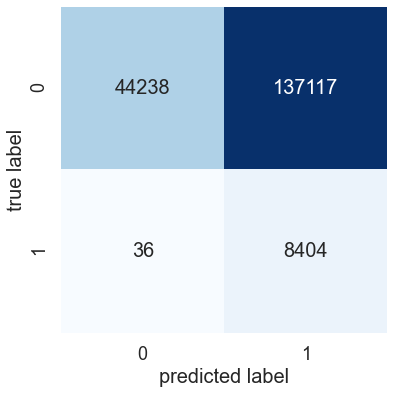

--------------------------------------------------
0.35
Precision = 0.0735, Recall = 0.9755, f1 = 0.1366


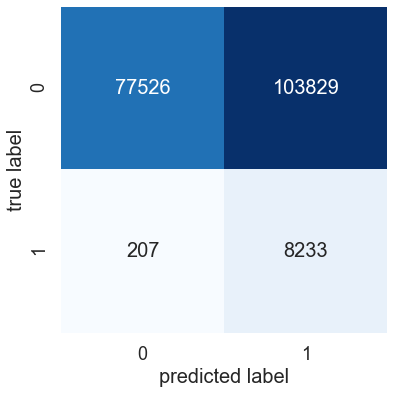

--------------------------------------------------
0.5
Precision = 0.0910, Recall = 0.9366, f1 = 0.1659


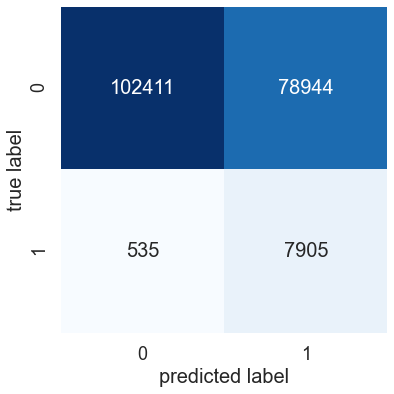

In [ ]:
for threshold in [0.2,0.35,0.5]:
    print('-'*50)
    print(threshold)
    
    y_scores = model_RF.predict_proba(X_test_res)[:,1]
    y_pred = [1 if score >= threshold else 0 for score in y_scores]
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    
    mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

In [ ]:
features = list(X_train_res.columns)
importances = model_RF.feature_importances_
indices = np.argsort(importances)[::-1]
percentage = 0

df_important = pd.DataFrame()
df_important['Col'] = Common_Column
df_important['Importances'] = 0

for f in range(len(features)):
    col = features[indices[f]]
    
    if col in Numerical_Cols:
        df_important.loc[df_important.Col == col, 'Importances'] = importances[indices[f]]*100
    else:
        boo = [str(ii) in col for ii in list(df_important.Col)]
        df_important.loc[boo, 'Importances'] += importances[indices[f]]*100

df_important.sort_values(by='Importances', ascending=False).head(30).to_csv('feature_importance.csv', index = False)
# for ii in range(len(df_important)):
#     if percentage > 70:
#         break
    
#     percentage += df_important.Importances[ii]
    
# df_important.iloc[:ii]

False

In [ ]:
#Feature importance ranking

features = list(X_train_res.columns)
importances = model_RF.feature_importances_
indices = np.argsort(importances)[::-1]
percentage = 0

# Print the feature ranking
print("Feature ranking:")

for f in range(len(features)):
    print("%2d. %30s (%.2f%%)" % (f + 1, features[indices[f]], importances[indices[f]]*100))
    percentage = percentage + importances[indices[f]]*100;
    if percentage >= 70:
        break;

print(percentage)

Feature ranking:
 1.                            Age (6.17%)
 2.      SUPERSTRUCTURE_COND_059_9 (4.02%)
 3.     SUPERSTRUCTURE_COND_059_10 (3.90%)
 4.      SUPERSTRUCTURE_COND_059_8 (3.29%)
 5.      SUPERSTRUCTURE_COND_059_7 (2.45%)
 6.           INVENTORY_RATING_066 (2.44%)
 7.          STRUCTURAL_EVAL_067_7 (2.17%)
 8.       SUBSTRUCTURE_COND_060_10 (2.08%)
 9.           OPERATING_RATING_064 (1.97%)
10.                        LAT_016 (1.85%)
11.                       LONG_017 (1.83%)
12.        SUBSTRUCTURE_COND_060_9 (1.66%)
13.            MAX_SPAN_LEN_MT_048 (1.59%)
14.                 IMP_LEN_MT_076 (1.55%)
15.           ROADWAY_WIDTH_MT_051 (1.54%)
16.                        ADT_029 (1.53%)
17.              DECK_WIDTH_MT_052 (1.52%)
18.           STRUCTURE_LEN_MT_049 (1.50%)
19.                 FUTURE_ADT_114 (1.50%)
20.                HORR_CLR_MT_047 (1.38%)
21.              APPR_WIDTH_MT_032 (1.35%)
22.          STRUCTURAL_EVAL_067_8 (1.28%)
23.               DETOUR_KILOS_019 (1

### Case 2
Predict health condition of bridges which should be inspeced in 2018 based on  previous two-consecutive inspection results.

In [ ]:
year = 2018
depth = 2

delta_Num = ['DETOUR_KILOS_019','ADT_029', 'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060',
             'CHANNEL_COND_061', 'OPERATING_RATING_064', 'INVENTORY_RATING_066','STRUCTURAL_EVAL_067',
             'DECK_GEOMETRY_EVAL_068', 'UNDCLRENCE_EVAL_069','POSTING_EVAL_070','WATERWAY_EVAL_071',
             'APPR_ROAD_EVAL_072','PERCENT_ADT_TRUCK_109', 'FUTURE_ADT_114']

Pretty_Print(delta_Num, 'Time-changing Features',2,62)

--------------------------------------------------------------
                    Time-changing Features                    
--------------------------------------------------------------
 019  : DETOUR_KILOS               029  : ADT                      
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND        
 061  : CHANNEL_COND               064  : OPERATING_RATING         
 066  : INVENTORY_RATING           067  : STRUCTURAL_EVAL          
 068  : DECK_GEOMETRY_EVAL         069  : UNDCLRENCE_EVAL          
 070  : POSTING_EVAL               071  : WATERWAY_EVAL            
 072  : APPR_ROAD_EVAL             109  : PERCENT_ADT_TRUCK        
 114  : FUTURE_ADT               


In [ ]:
ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
v = ins.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

In [ ]:
X_train = pd.DataFrame()

cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year + 1))]
v = cond.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

for col, df in df_dict.items():

  #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] < year)  & (ins.count(axis=1) > depth) & 
                (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)])]

    if col == 'DECK_COND_058':
        y_train = np.where(df.iloc[:,-1] <= 6, 1, 0)
    else:
        if col in delta_Num:
            X_train[col] = df.iloc[:,-3:-1].mean(axis = 1)
            X_train[col + '_std']  = df.iloc[:,-3:-1].std(axis = 1)
            X_train[col + '_diff_1'] = np.subtract(df.iloc[:,-2],df.iloc[:,-3])
        else:
            X_train[col] = df.iloc[:,-2]

X_train = X_train.reset_index(drop = True)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("Number of deficient bridges: ", np.sum(y_train))

X_train shape:  (445113, 104)
y_train shape:  (445113,)
Number of deficient bridges:  225570


In [ ]:
X_test = pd.DataFrame()

for col, df in df_dict.items():

    #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)])]
    if col == 'DECK_COND_058':
        y_test = np.where(df.iloc[:,-1] <= 4, 1, 0)
    else:
        if col in delta_Num:
            X_test[col] = df.iloc[:,-3:-1].mean(axis = 1)
            X_test[col + '_std']  = df.iloc[:,-3:-1].std(axis = 1)
            X_test[col + '_diff_1'] = np.subtract(df.iloc[:,-2],df.iloc[:,-3])
        else:
            X_test[col]  = df.iloc[:,-2]

X_test = X_test.reset_index(drop = True)
print("X_test  shape: ", X_test.shape)
print("y_test  shape: ", y_test.shape)
print("Number of deficient bridges: ", np.sum(y_test))

X_test  shape:  (167912, 104)
y_test  shape:  (167912,)
Number of deficient bridges:  7773


In [ ]:
sm = SMOTENC(sampling_strategy='not majority', categorical_features = X_train.columns.isin(Cat_Cols), random_state=77)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
#rus = RandomUnderSampler(random_state=77)
#X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
unique, counts = np.unique(y_train_res, return_counts=True)
print(dict(zip(unique, counts)))

{0: 225570, 1: 225570}


In [ ]:
X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

chch1 = set(X_train_res.columns.values)
chch2 = set(X_test_res.columns.values)

mutual = chch1.intersection(chch2)

X_train_res = X_train_res[mutual]
X_test_res  = X_test_res[mutual]

print(X_train_res.shape, X_test_res.shape)

(451140, 432) (167912, 432)


In [ ]:
model_RF_2 = RandomForestClassifier(n_estimators = 1000, random_state = 77)

%time model_RF_2.fit(X_train_res, y_train_res)
y_pred = model_RF_2.predict(X_test_res)
print(classification_report(y_test, y_pred))

Wall time: 36min 58s
              precision    recall  f1-score   support

           0       1.00      0.55      0.71    160139
           1       0.09      0.94      0.17      7773

    accuracy                           0.57    167912
   macro avg       0.54      0.75      0.44    167912
weighted avg       0.95      0.57      0.68    167912



--------------------------------------------------
0.3
Precision = 0.0672, Recall = 0.9909, f1 = 0.1259


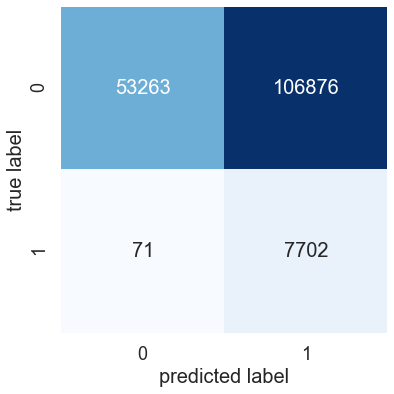

--------------------------------------------------
0.4
Precision = 0.0796, Recall = 0.9745, f1 = 0.1472


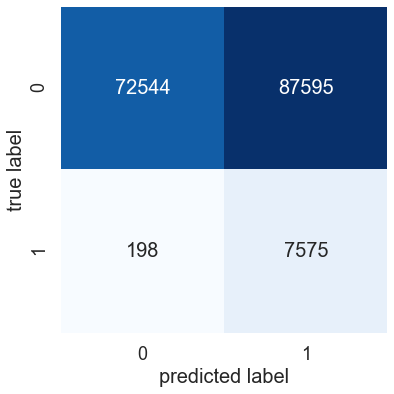

--------------------------------------------------
0.5
Precision = 0.0924, Recall = 0.9449, f1 = 0.1684


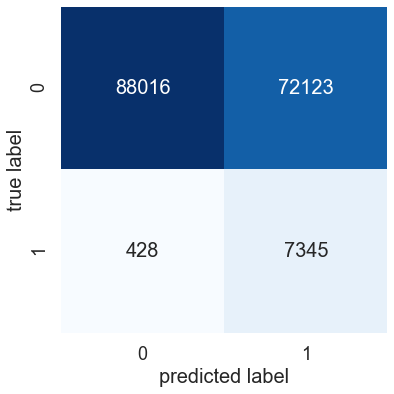

In [ ]:
for threshold in [0.3,0.4,0.5]:
    print('-'*50)
    print(threshold)
    
    y_scores = model_RF_2.predict_proba(X_test_res)[:,1]
    y_pred = [1 if score >= threshold else 0 for score in y_scores]
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    
    mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

### Case 3
Same target as case 1 and 2, but based on three-consecutive previous inspections.

In [ ]:
year = 2018
depth = 3

# delta_Num = ['DETOUR_KILOS_019','ADT_029', 'SUPERSTRUCTURE_COND_059', 'SUBSTRUCTURE_COND_060',
#              'CHANNEL_COND_061', 'OPERATING_RATING_064', 'INVENTORY_RATING_066','STRUCTURAL_EVAL_067',
#              'DECK_GEOMETRY_EVAL_068', 'UNDCLRENCE_EVAL_069','POSTING_EVAL_070','WATERWAY_EVAL_071',
#              'APPR_ROAD_EVAL_072','PERCENT_ADT_TRUCK_109', 'FUTURE_ADT_114']

Pretty_Print(delta_Num, 'Time-changing Features',2,62)

--------------------------------------------------------------
                    Time-changing Features                    
--------------------------------------------------------------
 019  : DETOUR_KILOS               029  : ADT                      
 059  : SUPERSTRUCTURE_COND        060  : SUBSTRUCTURE_COND        
 061  : CHANNEL_COND               064  : OPERATING_RATING         
 066  : INVENTORY_RATING           067  : STRUCTURAL_EVAL          
 068  : DECK_GEOMETRY_EVAL         069  : UNDCLRENCE_EVAL          
 070  : POSTING_EVAL               071  : WATERWAY_EVAL            
 072  : APPR_ROAD_EVAL             109  : PERCENT_ADT_TRUCK        
 114  : FUTURE_ADT               


In [ ]:
ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
v = ins.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

In [ ]:
X_train = pd.DataFrame()

cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year + 1))]
v = cond.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

for col, df in df_dict.items():

    #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] < year) & (ins.count(axis=1) > depth) &
              (cond[str(year)] <= cond[str(year-1)]) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]

    if col == 'DECK_COND_058':
        y_train = np.where(df.iloc[:,-1] <= 6, 1, 0)
    else:
        if col in delta_Num:
            X_train[col] = df.iloc[:,-4:-1].mean(axis = 1)
            X_train[col + '_std']  = df.iloc[:,-4:-1].std(axis = 1)
            X_train[col + '_diff_1'] = np.subtract(df.iloc[:,-2],df.iloc[:,-3])
            X_train[col + '_diff_2'] = np.subtract(df.iloc[:,-3],df.iloc[:,-4])
        else:
            X_train[col] = df.iloc[:,-2]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("Number of deficient bridges: ", np.sum(y_train))

X_train shape:  (387250, 119)
y_train shape:  (387250,)
Number of deficient bridges:  198918


In [ ]:
X_test = pd.DataFrame()

for col, df in df_dict.items():

    #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth) & (cond[str(year-1)] <= cond[str(year-2)]) & (cond[str(year-2)] <= cond[str(year-3)])]
    if col == 'DECK_COND_058':
        y_test = np.where(df.iloc[:,-1] <= 4, 1, 0)
    else:
        if col in delta_Num:
            X_test[col] = df.iloc[:,-4:-1].mean(axis = 1)
            X_test[col + '_std']  = df.iloc[:,-4:-1].std(axis = 1)
            X_test[col + '_diff_1'] = np.subtract(df.iloc[:,-2],df.iloc[:,-3])
            X_test[col + '_diff_2'] = np.subtract(df.iloc[:,-3],df.iloc[:,-4])
        else:
            X_test[col] = df.iloc[:,-2]

X_test = X_test.reset_index(drop = False)
print("X_test  shape: ", X_test.shape)
print("y_test  shape: ", y_test.shape)
print("Number of deficient bridges: ", np.sum(y_test))

X_test  shape:  (103904, 120)
y_test  shape:  (103904,)
Number of deficient bridges:  5045


In [ ]:
sm = SMOTENC(sampling_strategy='not majority', categorical_features = X_train.columns.isin(Cat_Cols), random_state=77)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
#rus = RandomUnderSampler(random_state=77)
#X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
unique, counts = np.unique(y_train_res, return_counts=True)
print(dict(zip(unique, counts)))

{0: 198918, 1: 198918}


In [ ]:
idx = X_test['index']
X_test.drop(columns='index')

X_train_res[Cat_Cols] = X_train_res[Cat_Cols].astype(int)
X_test[Cat_Cols]  = X_test[Cat_Cols].astype(int)

X_train_res = pd.get_dummies(X_train_res, columns = Cat_Cols)
X_test_res  = pd.get_dummies(X_test, columns = Cat_Cols)

chch1 = set(X_train_res.columns.values)
chch2 = set(X_test_res.columns.values)

mutual = chch1.intersection(chch2)

X_train_res = X_train_res[mutual]
X_test_res  = X_test_res[mutual]

print(X_train_res.shape, X_test_res.shape)

(397836, 443) (103904, 443)


In [ ]:
model_RF_3 = RandomForestClassifier(n_estimators = 1000, random_state = 77)

%time model_RF_3.fit(X_train_res, y_train_res)
y_pred = model_RF_3.predict(X_test_res)
print(classification_report(y_test, y_pred))

Wall time: 34min 57s
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     98859
           1       0.10      0.94      0.18      5045

    accuracy                           0.59    103904
   macro avg       0.55      0.76      0.46    103904
weighted avg       0.95      0.59      0.70    103904



In [ ]:
threshold = 0.2
y_scores = model_RF_3.predict_proba(X_test_res)[:,1]
y_pred = [1 if score >= threshold else 0 for score in y_scores]
print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))

Precision = 0.0597, Recall = 0.9974, f1 = 0.1127


In [ ]:
df = df_dict['DECK_COND_058'].iloc[idx.loc[(np.array(y_pred) == 0) & (np.array(y_test) == 1)]]
df = df.iloc[:,:df.columns.get_loc(str(year+1))]
v = df.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')

df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
df #.loc[df['2017'] - df['2018'] >= 3]

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,5.0,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,4.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,4.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,6.0,5.0,4.0,4.0,4.0,4.0,4.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,7.0,7.0,6.0,6.0,5.0,5.0,4.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,7.0,7.0,6.0,6.0,6.0,6.0,6.0,4.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,4.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,9.0,9.0,8.0,8.0,8.0,8.0,8.0,8.0,4.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.0,7.0,7.0,4.0,4.0


--------------------------------------------------
0.3
Precision = 0.0713, Recall = 0.9905, f1 = 0.1330


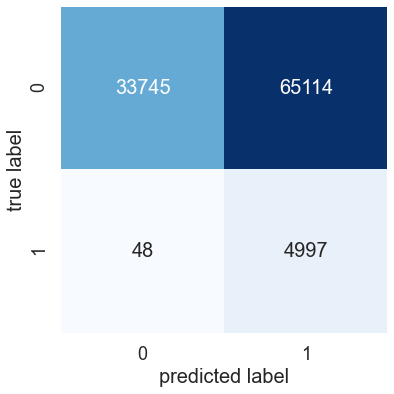

--------------------------------------------------
0.4
Precision = 0.0859, Recall = 0.9740, f1 = 0.1579


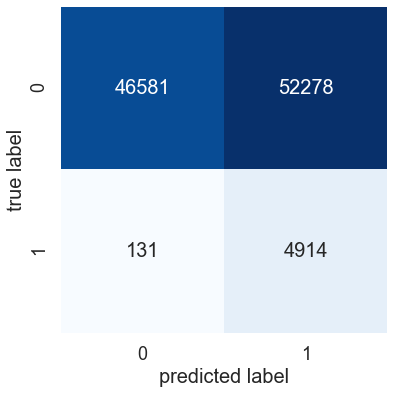

--------------------------------------------------
0.5
Precision = 0.1012, Recall = 0.9429, f1 = 0.1827


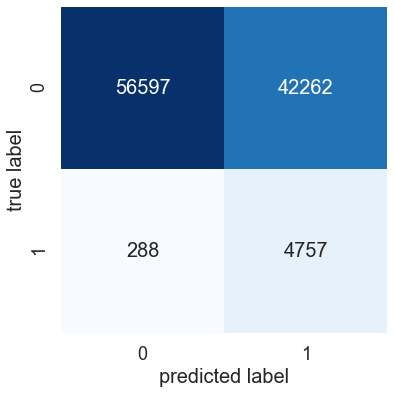

In [ ]:
for threshold in [0.3,0.4,0.5]:
    print('-'*50)
    print(threshold)
    
    y_scores = model_RF_3.predict_proba(X_test_res)[:,1]
    y_pred = [1 if score >= threshold else 0 for score in y_scores]
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    
    mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

## Deep Learning Model Attempt: Entity Embeddings

### Training Set, Testing Set

In [ ]:
year = 2018
depth = 1

In [ ]:
ins = ins_yr.iloc[:,:ins_yr.columns.get_loc(str(year+1))]
v = ins.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
ins = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

In [ ]:
X_train = pd.DataFrame()

cond = df_dict['DECK_COND_058'].iloc[:,:df_dict['DECK_COND_058'].columns.get_loc(str(year + 1))]
v = cond.values
a = (~np.isnan(v)).argsort(1, kind='mergesort')
cond = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = ins.columns)

for col, df in df_dict.items():

  #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] < year) & (ins.count(axis=1) > depth) & (cond[str(year)] <= cond[str(year - 1)])]

    if col == 'DECK_COND_058':
        y_train = np.where(df.iloc[:,-1] <= 6, 1, 0)
    else:
        X_train[col] = df.iloc[:,-2]

X_train = X_train.reset_index(drop = True)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("Number of deficient bridges: ", np.sum(y_train))

X_train shape:  (592656, 74)
y_train shape:  (592656,)
Number of deficient bridges:  293077


In [ ]:
X_test = pd.DataFrame()

for col, df in df_dict.items():

    #------Move to the Right------
    df = df.iloc[:,:df.columns.get_loc(str(year+1))]
    v = df.values
    a = (~np.isnan(v)).argsort(1, kind='mergesort')

    df = pd.DataFrame(v[np.arange(a.shape[0])[:, None], a], columns = df.columns)
    #-----------------------------

    df = df.loc[(ins[str(year)] == year) & (ins.count(axis=1) > depth)]
    if col == 'DECK_COND_058':
        y_test = np.where(df.iloc[:,-1] <= 4, 1, 0)
    else:
        X_test[col] = df.iloc[:,-2]


X_test = X_test.reset_index(drop = True)
print("X_test  shape: ", X_test.shape)
print("y_test  shape: ", y_test.shape)
print("Number of deficient bridges: ", np.sum(y_test))

X_test  shape:  (189795, 74)
y_test  shape:  (189795,)
Number of deficient bridges:  8440


In [ ]:
rus = RandomUnderSampler(random_state=77)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns)
unique, counts = np.unique(y_train_res, return_counts=True)
print(dict(zip(unique, counts)))

{0: 293077, 1: 293077}


### Model

In [ ]:
def categorify(df, cat_vars):
    categories = {}
    for cat in cat_vars:
        df[cat] = df[cat].astype("category").cat.as_ordered()
        categories[cat] = df[cat].cat.categories
    return categories

In [ ]:
# get embedding size for each categorical variable
def get_emb_sz(cat_col,categories_dict):
    num_classes = len(categories_dict[cat_col])
    return int(min(600,round(1.6*num_classes**0.56)))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_res, y_train_res,
                                                  test_size=0.2, random_state=77, stratify=y_train_res)

X_train = pd.DataFrame(X_train, columns=X_train_res.columns)
X_val   = pd.DataFrame(X_val, columns=X_train_res.columns)

print("Training   set: ", X_train.shape, y_train.shape)
print("Validation set: ", X_val.shape, y_val.shape)
print("Testing    set: ", X_test.shape, y_test.shape)

Training   set:  (468923, 74) (468923,)
Validation set:  (117231, 74) (117231,)
Testing    set:  (189795, 74) (189795,)


In [ ]:
# define the neural networks
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Dropout, BatchNormalization,Conv1D,Flatten
from tensorflow.keras import Model

def combined_network(cat_vars,categories_dict,cont_vars, layers):
    tf.keras.backend.clear_session()

    inputs = []
    embeddings = []
    emb_dict ={}

    # create embedding layer for each categorical variables
    for i in range(len(cat_vars)):
        emb_dict[cat_vars[i]] = Input(shape=(1,))
        emb_sz = get_emb_sz(cat_vars[i],categories_dict)
        vocab = len(categories_dict[cat_vars[i]]) +10
        embedding = Embedding(vocab,emb_sz,input_length=1)(emb_dict[cat_vars[i]])
        embedding = Reshape(target_shape=(emb_sz,))(embedding)
        inputs.append(emb_dict[cat_vars[i]])
        embeddings.append(embedding)

        #print("Col: ", cat_vars[i], ", Vocab: ", vocab, ", Embedding Size: ", emb_sz)

    # concat continuous variables with embedded variables
    cont_input = Input(shape=(len(cont_vars),))
    embedding = BatchNormalization()(cont_input)
    inputs.append(cont_input)
    embeddings.append(embedding)
    x = Concatenate()(embeddings)

    # add user-defined fully-connected layers separated with batchnorm and dropout layers
    for i in range(len(layers)):
        if i == 0:
            x = Dense(layers[i],activation="relu")(x)
        else:
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
            x = Dense(layers[i],activation="relu")(x)

    output = Dense(1,activation="sigmoid")(x)
    model = Model(inputs,output)
    return model

In [ ]:
# Modify x_train, x_val, x_test input to fit model
input_list = []
val_list = []
test_list = []

for i in Cat_Cols:
    input_list.append(tf.convert_to_tensor(X_train[i].values, dtype=np.float32))
    val_list.append(tf.convert_to_tensor(X_val[i].values, dtype=np.float32))
    test_list.append(tf.convert_to_tensor(X_test[i].values, dtype=np.float32))

input_list.append(tf.convert_to_tensor(X_train[Numerical_Cols].values, dtype=np.float32))
val_list.append(tf.convert_to_tensor(X_val[Numerical_Cols].values, dtype=np.float32))
test_list.append(tf.convert_to_tensor(X_test[Numerical_Cols].values, dtype=np.float32))

In [ ]:
layers = [64,32]
categories = categorify(X_train, Cat_Cols)
model = combined_network(Cat_Cols,categories,Numerical_Cols, layers)
opt = tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=["accuracy"])
#model.summary()

In [ ]:
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
import datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, embeddings_freq = 1)
mc = ModelCheckpoint('model_for_tensorboard.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history = model.fit(input_list, y_train, 
                    epochs=1000, batch_size = 1024,
                    validation_data=(val_list, y_val),
                    verbose = 1,
                    callbacks = [mc,tb])

Train on 468923 samples, validate on 117231 samples
Epoch 1/1000
468923/468923 [==============================] - 10s 20us/sample - loss: 0.6550 - accuracy: 0.6631 - val_loss: 0.4972 - val_accuracy: 0.7722
Epoch 2/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.5028 - accuracy: 0.7731 - val_loss: 0.4382 - val_accuracy: 0.8066
Epoch 3/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.4619 - accuracy: 0.7978 - val_loss: 0.4225 - val_accuracy: 0.8144
Epoch 4/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.4440 - accuracy: 0.8061 - val_loss: 0.4140 - val_accuracy: 0.8171
Epoch 5/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.4329 - accuracy: 0.8104 - val_loss: 0.4084 - val_accuracy: 0.8190
Epoch 6/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.4262 - accuracy: 0.8127 - val_loss: 0.4039 - val_accuracy: 0.8202
Epoch 7/1000
468923/468923 [=

Epoch 54/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3856 - accuracy: 0.8309 - val_loss: 0.3787 - val_accuracy: 0.8338
Epoch 55/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3851 - accuracy: 0.8313 - val_loss: 0.3782 - val_accuracy: 0.8338
Epoch 56/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3850 - accuracy: 0.8316 - val_loss: 0.3780 - val_accuracy: 0.8341
Epoch 57/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3853 - accuracy: 0.8315 - val_loss: 0.3780 - val_accuracy: 0.8338
Epoch 58/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3849 - accuracy: 0.8313 - val_loss: 0.3774 - val_accuracy: 0.8344
Epoch 59/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3846 - accuracy: 0.8316 - val_loss: 0.3776 - val_accuracy: 0.8342
Epoch 60/1000
468923/468923 [==============================] - 6s 12us/sampl

Epoch 160/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3742 - accuracy: 0.8359 - val_loss: 0.3731 - val_accuracy: 0.8372
Epoch 161/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3744 - accuracy: 0.8361 - val_loss: 0.3726 - val_accuracy: 0.8375
Epoch 162/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3742 - accuracy: 0.8361 - val_loss: 0.3729 - val_accuracy: 0.8373
Epoch 163/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3743 - accuracy: 0.8362 - val_loss: 0.3730 - val_accuracy: 0.8375
Epoch 164/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3741 - accuracy: 0.8364 - val_loss: 0.3727 - val_accuracy: 0.8374
Epoch 165/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3739 - accuracy: 0.8362 - val_loss: 0.3729 - val_accuracy: 0.8376
Epoch 166/1000
468923/468923 [==============================] - 6s 12u

Epoch 265/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3696 - accuracy: 0.8384 - val_loss: 0.3734 - val_accuracy: 0.8381
Epoch 266/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3697 - accuracy: 0.8383 - val_loss: 0.3740 - val_accuracy: 0.8386
Epoch 267/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3698 - accuracy: 0.8377 - val_loss: 0.3734 - val_accuracy: 0.8386
Epoch 268/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3696 - accuracy: 0.8382 - val_loss: 0.3742 - val_accuracy: 0.8385
Epoch 269/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3692 - accuracy: 0.8381 - val_loss: 0.3740 - val_accuracy: 0.8385
Epoch 270/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3693 - accuracy: 0.8383 - val_loss: 0.3738 - val_accuracy: 0.8385
Epoch 271/1000
468923/468923 [==============================] - 6s 12u

Epoch 318/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3682 - accuracy: 0.8391 - val_loss: 0.3751 - val_accuracy: 0.8381
Epoch 319/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3683 - accuracy: 0.8388 - val_loss: 0.3752 - val_accuracy: 0.8383
Epoch 320/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3680 - accuracy: 0.8385 - val_loss: 0.3741 - val_accuracy: 0.8385
Epoch 321/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3678 - accuracy: 0.8390 - val_loss: 0.3750 - val_accuracy: 0.8382
Epoch 322/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3676 - accuracy: 0.8387 - val_loss: 0.3744 - val_accuracy: 0.8384
Epoch 323/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3679 - accuracy: 0.8386 - val_loss: 0.3750 - val_accuracy: 0.8382
Epoch 324/1000
468923/468923 [==============================] - 6s 12u

Epoch 371/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3668 - accuracy: 0.8393 - val_loss: 0.3762 - val_accuracy: 0.8379
Epoch 372/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3669 - accuracy: 0.8393 - val_loss: 0.3770 - val_accuracy: 0.8382
Epoch 373/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3672 - accuracy: 0.8392 - val_loss: 0.3752 - val_accuracy: 0.8385
Epoch 374/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3667 - accuracy: 0.8397 - val_loss: 0.3750 - val_accuracy: 0.8382
Epoch 375/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3665 - accuracy: 0.8392 - val_loss: 0.3758 - val_accuracy: 0.8384
Epoch 376/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3669 - accuracy: 0.8393 - val_loss: 0.3757 - val_accuracy: 0.8383
Epoch 377/1000
468923/468923 [==============================] - 6s 12u

Epoch 424/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3659 - accuracy: 0.8401 - val_loss: 0.3758 - val_accuracy: 0.8382
Epoch 425/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3653 - accuracy: 0.8398 - val_loss: 0.3760 - val_accuracy: 0.8389
Epoch 426/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3664 - accuracy: 0.8390 - val_loss: 0.3770 - val_accuracy: 0.8382
Epoch 427/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3660 - accuracy: 0.8396 - val_loss: 0.3768 - val_accuracy: 0.8387
Epoch 428/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3664 - accuracy: 0.8394 - val_loss: 0.3761 - val_accuracy: 0.8383
Epoch 429/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3657 - accuracy: 0.8400 - val_loss: 0.3768 - val_accuracy: 0.8386
Epoch 430/1000
468923/468923 [==============================] - 6s 12u

Epoch 529/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3646 - accuracy: 0.8404 - val_loss: 0.3780 - val_accuracy: 0.8386
Epoch 530/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3643 - accuracy: 0.8399 - val_loss: 0.3777 - val_accuracy: 0.8383
Epoch 531/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3647 - accuracy: 0.8400 - val_loss: 0.3773 - val_accuracy: 0.8388
Epoch 532/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3637 - accuracy: 0.8406 - val_loss: 0.3773 - val_accuracy: 0.8390
Epoch 533/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3645 - accuracy: 0.8399 - val_loss: 0.3764 - val_accuracy: 0.8386
Epoch 534/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3640 - accuracy: 0.8405 - val_loss: 0.3780 - val_accuracy: 0.8383
Epoch 535/1000
468923/468923 [==============================] - 6s 12u

Epoch 582/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3642 - accuracy: 0.8400 - val_loss: 0.3787 - val_accuracy: 0.8386
Epoch 583/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3636 - accuracy: 0.8403 - val_loss: 0.3780 - val_accuracy: 0.8387
Epoch 584/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3638 - accuracy: 0.8409 - val_loss: 0.3778 - val_accuracy: 0.8389
Epoch 585/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3637 - accuracy: 0.8404 - val_loss: 0.3770 - val_accuracy: 0.8392
Epoch 586/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3640 - accuracy: 0.8403 - val_loss: 0.3777 - val_accuracy: 0.8390
Epoch 587/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3636 - accuracy: 0.8403 - val_loss: 0.3773 - val_accuracy: 0.8387
Epoch 588/1000
468923/468923 [==============================] - 5s 12u

Epoch 635/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3636 - accuracy: 0.8404 - val_loss: 0.3776 - val_accuracy: 0.8391
Epoch 636/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3631 - accuracy: 0.8405 - val_loss: 0.3770 - val_accuracy: 0.8389
Epoch 637/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3627 - accuracy: 0.8410 - val_loss: 0.3786 - val_accuracy: 0.8386
Epoch 638/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3633 - accuracy: 0.8408 - val_loss: 0.3778 - val_accuracy: 0.8386
Epoch 639/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3634 - accuracy: 0.8405 - val_loss: 0.3788 - val_accuracy: 0.8387
Epoch 640/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3632 - accuracy: 0.8405 - val_loss: 0.3778 - val_accuracy: 0.8390
Epoch 641/1000
468923/468923 [==============================] - 6s 12u

Epoch 688/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3630 - accuracy: 0.8410 - val_loss: 0.3776 - val_accuracy: 0.8390
Epoch 689/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3629 - accuracy: 0.8407 - val_loss: 0.3783 - val_accuracy: 0.8387
Epoch 690/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3628 - accuracy: 0.8410 - val_loss: 0.3780 - val_accuracy: 0.8390
Epoch 691/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3626 - accuracy: 0.8415 - val_loss: 0.3774 - val_accuracy: 0.8390
Epoch 692/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3633 - accuracy: 0.8408 - val_loss: 0.3767 - val_accuracy: 0.8387
Epoch 693/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3633 - accuracy: 0.8407 - val_loss: 0.3767 - val_accuracy: 0.8390
Epoch 694/1000
468923/468923 [==============================] - 6s 12u

Epoch 741/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3624 - accuracy: 0.8413 - val_loss: 0.3765 - val_accuracy: 0.8388
Epoch 742/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3627 - accuracy: 0.8409 - val_loss: 0.3782 - val_accuracy: 0.8393
Epoch 743/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3627 - accuracy: 0.8414 - val_loss: 0.3776 - val_accuracy: 0.8390
Epoch 744/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3625 - accuracy: 0.8411 - val_loss: 0.3782 - val_accuracy: 0.8390
Epoch 745/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3621 - accuracy: 0.8414 - val_loss: 0.3776 - val_accuracy: 0.8387
Epoch 746/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3630 - accuracy: 0.8412 - val_loss: 0.3775 - val_accuracy: 0.8392
Epoch 747/1000
468923/468923 [==============================] - 6s 12u

Epoch 794/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3623 - accuracy: 0.8414 - val_loss: 0.3780 - val_accuracy: 0.8390
Epoch 795/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3616 - accuracy: 0.8415 - val_loss: 0.3774 - val_accuracy: 0.8390
Epoch 796/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3622 - accuracy: 0.8412 - val_loss: 0.3785 - val_accuracy: 0.8384
Epoch 797/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3624 - accuracy: 0.8413 - val_loss: 0.3789 - val_accuracy: 0.8386
Epoch 798/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3625 - accuracy: 0.8410 - val_loss: 0.3784 - val_accuracy: 0.8389
Epoch 799/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3624 - accuracy: 0.8414 - val_loss: 0.3784 - val_accuracy: 0.8390
Epoch 800/1000
468923/468923 [==============================] - 6s 12u

Epoch 847/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3618 - accuracy: 0.8415 - val_loss: 0.3775 - val_accuracy: 0.8383
Epoch 848/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3621 - accuracy: 0.8413 - val_loss: 0.3780 - val_accuracy: 0.8389
Epoch 849/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3623 - accuracy: 0.8409 - val_loss: 0.3782 - val_accuracy: 0.8384
Epoch 850/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3620 - accuracy: 0.8414 - val_loss: 0.3788 - val_accuracy: 0.8387
Epoch 851/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3618 - accuracy: 0.8417 - val_loss: 0.3767 - val_accuracy: 0.8389
Epoch 852/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3620 - accuracy: 0.8416 - val_loss: 0.3785 - val_accuracy: 0.8385
Epoch 853/1000
468923/468923 [==============================] - 6s 12u

Epoch 900/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3613 - accuracy: 0.8421 - val_loss: 0.3777 - val_accuracy: 0.8386
Epoch 901/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3616 - accuracy: 0.8414 - val_loss: 0.3787 - val_accuracy: 0.8387
Epoch 902/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3620 - accuracy: 0.8412 - val_loss: 0.3783 - val_accuracy: 0.8387
Epoch 903/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3617 - accuracy: 0.8417 - val_loss: 0.3783 - val_accuracy: 0.8388
Epoch 904/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3620 - accuracy: 0.8415 - val_loss: 0.3789 - val_accuracy: 0.8389
Epoch 905/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3614 - accuracy: 0.8419 - val_loss: 0.3779 - val_accuracy: 0.8387
Epoch 906/1000
468923/468923 [==============================] - 6s 12u

Epoch 953/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3613 - accuracy: 0.8419 - val_loss: 0.3782 - val_accuracy: 0.8386
Epoch 954/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3616 - accuracy: 0.8414 - val_loss: 0.3782 - val_accuracy: 0.8387
Epoch 955/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3616 - accuracy: 0.8417 - val_loss: 0.3777 - val_accuracy: 0.8387
Epoch 956/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3611 - accuracy: 0.8417 - val_loss: 0.3778 - val_accuracy: 0.8389
Epoch 957/1000
468923/468923 [==============================] - 5s 12us/sample - loss: 0.3609 - accuracy: 0.8422 - val_loss: 0.3781 - val_accuracy: 0.8388
Epoch 958/1000
468923/468923 [==============================] - 6s 12us/sample - loss: 0.3610 - accuracy: 0.8423 - val_loss: 0.3773 - val_accuracy: 0.8387
Epoch 959/1000
468923/468923 [==============================] - 6s 12u

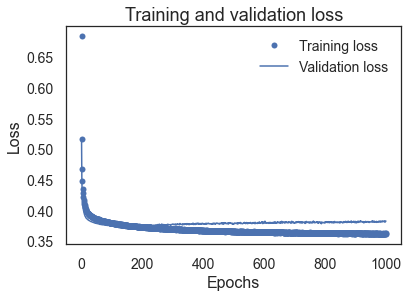

In [ ]:
sns.set_style("white")

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize = 14)

plt.show()

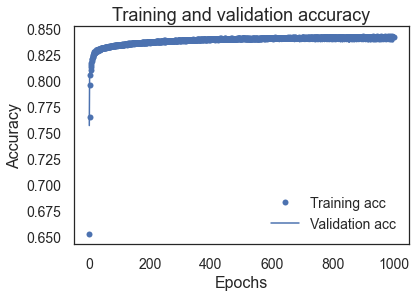

In [ ]:
sns.set_style("white")
plt.clf()   # clear figure
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy',fontsize=18)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize = 14)

plt.show()

--------------------------------------------------
0.5
Precision = 0.0921, Recall = 0.9410, f1 = 0.1677


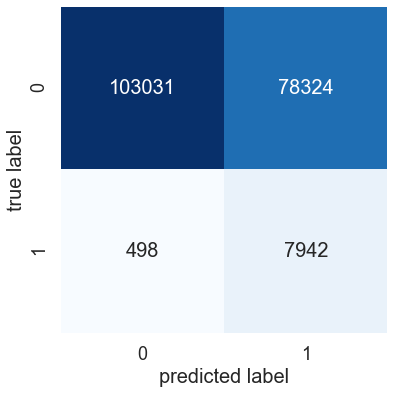

--------------------------------------------------
0.4
Precision = 0.0833, Recall = 0.9603, f1 = 0.1533


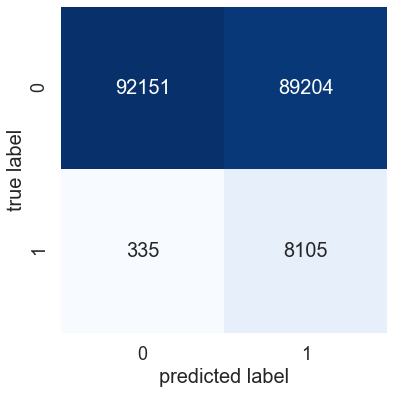

--------------------------------------------------
0.35
Precision = 0.0791, Recall = 0.9678, f1 = 0.1463


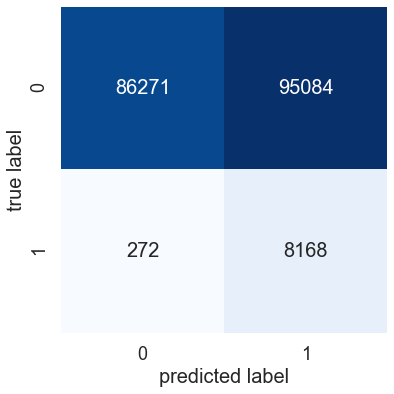

--------------------------------------------------
0.3
Precision = 0.0750, Recall = 0.9758, f1 = 0.1393


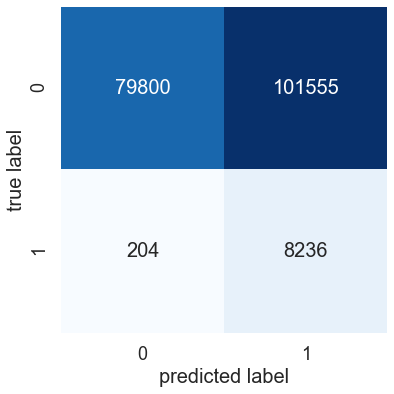

--------------------------------------------------
0.2
Precision = 0.0652, Recall = 0.9866, f1 = 0.1224


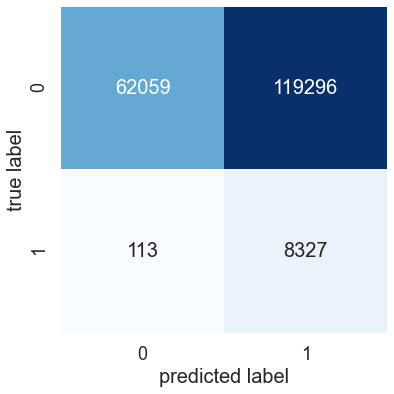

In [ ]:
saved_model = tf.keras.models.load_model('best_model_embeddings_1000.h5')

for threshold in [0.5,0.4,0.35,0.3,0.2]:
    print('-'*50)
    print(threshold)
    
    y_score = saved_model.predict(test_list)
    y_pred = [1 if score >= threshold else 0 for score in y_score]
    print("Precision = %.4f, Recall = %.4f, f1 = %.4f" % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    
    mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap="Blues", annot_kws={"size": 20})
    plt.xlabel('predicted label',fontsize=20)
    plt.ylabel('true label',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()